# Map-Reduce: summarize long texts via parallelization

Let's unpack the map reduce approach. For this, we'll first map each document to an individual summary using an LLM. Then we'll reduce or consolidate those summaries into a single global summary.

Note that the map step is typically parallelized over the input documents.

LangGraph, built on top of langchain-core, suports map-reduce workflows and is well-suited to this problem:

https://langchain-ai.github.io/langgraph/how-tos/map-reduce/


* LangGraph allows for individual steps (such as successive summarizations) to be streamed, allowing for greater control of execution;
* LangGraph's checkpointing supports error recovery, extending with human-in-the-loop workflows, and easier incorporation into conversational applications.

https://langchain-ai.github.io/langgraph/how-tos/persistence/

* The LangGraph implementation is straightforward to modify and extend, as we will see below.



# Important Note:

Note that map-reduce is especially effective when understanding of a sub-document does not rely on preceeding context. For example, when summarizing a corpus of many, shorter documents. In other cases, such as summarizing a novel or body of text with an inherent sequence, iterative refinement may be more effective.

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [6]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [8]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Auton

# Map

We'll first define the prompt associated with the map step, and associated it with the LLM via a chain. 

We can use the same summarization prompt as in the stuff approach, above:

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

# Prebuilt prompt:


We can also use the Prompt Hub to store and fetch prompts.

https://smith.langchain.com/hub/rlm/map-prompt


In [10]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")

c:\Code\Github\LangChain-Basics\venv\lib\site-packages\langchain\hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


# Reduce
We also define a chain that takes the document mapping results and reduces them into a single output.

In [11]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""


In [12]:

reduce_prompt = ChatPromptTemplate.from_messages([("human", reduce_template)])


In [13]:

reduce_chain = reduce_prompt | llm | StrOutputParser()

# Orchestration via LangGraph

Below we implement a simple application that:

1. maps the summarization step on a list of documents
2. then reduces them using the above prompts.

Map-reduce flows are particularly useful when texts are long compared to the context window of a LLM. 

For long texts, we need a mechanism that ensures that the context to be summarized in the reduce step does not exceed a model's context window size. 

Here we implement a recursive "collapsing" of the summaries: 

the inputs are partitioned based on a token limit, and summaries are generated of the partitions. 
This step is repeated until the total length of the summaries is within a desired limit, allowing for the summarization of arbitrary-length text.


# Chunk the document to fit LLM's context size:

First we chunk the blog post into smaller "sub documents" to be mapped:


**Note** that we define an artificially low maximum token length of 1,000 tokens to illustrate the "collapsing" step.

In [14]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


#  Define the Graph

Next, define the graph. 





In [15]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph


In [16]:
token_max = 1000

In [17]:
def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

# Define ```OverallState``` State

This will be the overall state of the main graph.

It will contain 
1. the input document contents,
2. corresponding summaries,
3. and a final summary.

Notice here we use the operator.add This is because we want combine all the summaries we generate from individual nodes back into one list - this is essentially the "reduce" part

In [18]:
class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str

# Define ```SummaryState```

This will be the state of the node that we will "map" all documents to in order to generate summaries



In [19]:
class SummaryState(TypedDict):
    content: str

# Generate Summary function


Here we generate a summary, given a document

In [20]:
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Logic to map out over the docs


Here we define the logic to map out over the documents  We will use this an edge in the graph.


This function returns a list of `Send` objects.

Each `Send` object consists of the name of a node in the graph as well as the state to send to that node

In [21]:
def map_summaries(state: OverallState):

    return [
        ("generate_summary", {"content": content}) for content in state["contents"]
    ]

In [22]:
def map_summaries(state: OverallState):

    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

In [23]:
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }

# Add node to collapse summaries


In [24]:

async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# Conditional Edge to determine collapsing

Conditional edge in the graph that determines  if we should collapse the summaries or not

In [25]:
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Generate Final Summary

In [26]:
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Build the graph

In [27]:

# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)


In [28]:

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)


In [29]:

app = graph.compile()

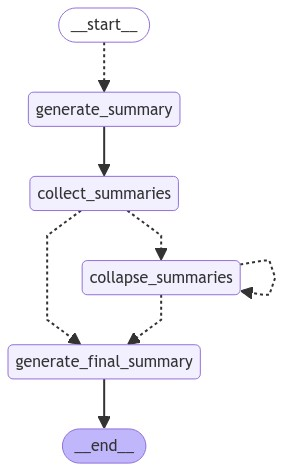

In [30]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

When running the application, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a recursion_limit on its execution. This will raise a specific error when the specified limit is exceeded.

In [31]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [32]:
print(step)



{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the documents is as follows:\n\n1. **Advancements in Language Models**: Significant progress in large language models (LLMs) has enabled the development of autonomous agents capable of complex task execution and decision-making.\n\n2. **Key Components of Autonomous Agents**: Essential elements include planning methods (like Chain of Thought and Tree of Thoughts), self-reflection for improvement (through frameworks such as ReAct and Reflexion), and various memory types (sensory, short-term, long-term) that enhance decision-making.\n\n3. **Integration of Tools**: The incorporation of external tools and APIs (e.g., MRKL, TALM, Toolformer) enhances LLM efficiency and decision-making across different domains.\n\n4. **Structured Development Practices**: Emphasis on systematic coding practices, including organized file structures and adherence to best practices in naming, documentation, and function